In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 18})

In [2]:
features = np.load(f'DataSet/Features_Diff_1.npz')['Features_Diff_1']
print(features.shape)

(151839, 71, 8)


In [3]:
data = features[0:90000]

In [4]:
input_window = 47
output_window = 24

# 用来存储输入和输出的列表
inputs = []
outputs = []

# 为了确保没有超出数组的界限，我们创建一个循环，截止到可以完整提取一个输入加一个输出的位置
for i in range(data.shape[1] - input_window - output_window + 1):
    # 对每一个样本处理
    for sample in data:
        inputs.append(sample[i:i + input_window])
        outputs.append(sample[i + input_window: i + input_window + output_window])

inputs = np.array(inputs)
outputs = np.array(outputs)

# 转换为torch.Tensor
inputs_tensor = torch.from_numpy(inputs).float()
outputs_tensor = torch.from_numpy(outputs).float()

# 划分训练集和测试集
num_samples = inputs_tensor.shape[0]
train_size = int(num_samples * 0.8)

train_inputs = inputs_tensor[:train_size]
train_outputs = outputs_tensor[:train_size]
test_inputs = inputs_tensor[train_size:]
test_outputs = outputs_tensor[train_size:]

# 创建数据集和数据加载器
train_dataset = TensorDataset(train_inputs, train_outputs)
train_loader = DataLoader(train_dataset, batch_size=180, shuffle=True, num_workers=16, pin_memory=True)

test_dataset = TensorDataset(test_inputs, test_outputs)
test_loader = DataLoader(test_dataset, batch_size=180, shuffle=False, num_workers=16, pin_memory=True)

# 验证输出形状
print("Train inputs shape:", train_inputs.shape)
print("Train outputs shape:", train_outputs.shape)
print("Test inputs shape:", test_inputs.shape)
print("Test outputs shape:", test_outputs.shape)

Train inputs shape: torch.Size([72000, 47, 8])
Train outputs shape: torch.Size([72000, 24, 8])
Test inputs shape: torch.Size([18000, 47, 8])
Test outputs shape: torch.Size([18000, 24, 8])


In [5]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        return hidden, cell

In [6]:
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden, cell):
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        prediction = self.fc(output)
        return prediction, hidden, cell

In [7]:
class DeepVAR(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(DeepVAR, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, num_layers)
        self.decoder = Decoder(input_dim, hidden_dim, output_dim, num_layers)
        
    def forward(self, src, trg = None, teacher_forcing_ratio=0.5):
        if trg == None:
            return self.predict(src,24)
        batch_size, trg_len, _ = trg.shape
        outputs = torch.zeros(batch_size, trg_len, trg.shape[2]).to(trg.device)
        
        hidden, cell = self.encoder(src)
        
        # 初始输入到解码器
        input = src[:, -1, :].unsqueeze(1)  # 取编码器的最后一个输出作为解码器的第一个输入
        
        for t in range(trg_len):
            # 插入输入token并接收输出
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t, :] = output.squeeze(1)
            # 决定是否使用真实的下一个输入或使用预测的输出
            input = trg[:, t, :].unsqueeze(1) if torch.rand(1) < teacher_forcing_ratio else output
        
        return outputs
    

    def predict(self, src, future_steps):
        batch_size, _, input_dim = src.shape
        outputs = torch.zeros(batch_size, future_steps, input_dim).to(src.device)
        
        hidden, cell = self.encoder(src)
        
        input = src[:, -1, :].unsqueeze(1)
        
        for t in range(future_steps):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t, :] = output.squeeze(1)
            input = output
        
        return outputs

In [15]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50):
    writer = SummaryWriter(log_dir='runs/DeepVAR')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        progress_bar = tqdm(train_loader, desc='Training', leave=True)
        for inputs, targets in progress_bar:
            optimizer.zero_grad()
            outputs = model(inputs, targets)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({'loss': loss.item()})
        train_loss /= len(train_loader.dataset)
        test_loss = evaluate_model(model, test_loader, criterion)
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/test', test_loss, epoch)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    writer.close()

In [16]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs, targets)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
    test_loss /= len(test_loader.dataset)
    return test_loss

In [17]:
# 参数设置
input_dim = 8
hidden_dim = 50
num_layers = 2
output_dim = 8
learning_rate = 0.001
# 创建模型
model = DeepVAR(input_dim, hidden_dim, output_dim, num_layers)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Model initialization
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)
# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50)

Training: 100%|██████████| 400/400 [02:33<00:00,  2.60it/s, loss=0.0546]


Epoch 1/50, Train Loss: 0.1075, Test Loss: 0.0680


Training: 100%|██████████| 400/400 [03:07<00:00,  2.14it/s, loss=0.0766]


Epoch 2/50, Train Loss: 0.0628, Test Loss: 0.0615


Training: 100%|██████████| 400/400 [03:37<00:00,  1.84it/s, loss=0.0443]


Epoch 3/50, Train Loss: 0.0519, Test Loss: 0.0497


Training: 100%|██████████| 400/400 [02:54<00:00,  2.29it/s, loss=0.0476]


Epoch 4/50, Train Loss: 0.0450, Test Loss: 0.0437


Training: 100%|██████████| 400/400 [02:58<00:00,  2.25it/s, loss=0.0468]


Epoch 5/50, Train Loss: 0.0409, Test Loss: 0.0417


Training: 100%|██████████| 400/400 [02:58<00:00,  2.24it/s, loss=0.0408]


Epoch 6/50, Train Loss: 0.0385, Test Loss: 0.0387


Training: 100%|██████████| 400/400 [03:10<00:00,  2.10it/s, loss=0.0265]


Epoch 7/50, Train Loss: 0.0358, Test Loss: 0.0407


Training: 100%|██████████| 400/400 [03:07<00:00,  2.14it/s, loss=0.0289]


Epoch 8/50, Train Loss: 0.0338, Test Loss: 0.0398


Training: 100%|██████████| 400/400 [02:31<00:00,  2.65it/s, loss=0.028] 


Epoch 9/50, Train Loss: 0.0322, Test Loss: 0.0355


Training: 100%|██████████| 400/400 [02:12<00:00,  3.02it/s, loss=0.0325]


Epoch 10/50, Train Loss: 0.0313, Test Loss: 0.0400


Training: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s, loss=0.0245]


Epoch 11/50, Train Loss: 0.0303, Test Loss: 0.0330


Training: 100%|██████████| 400/400 [01:39<00:00,  4.04it/s, loss=0.0285]


Epoch 12/50, Train Loss: 0.0292, Test Loss: 0.0323


Training: 100%|██████████| 400/400 [01:37<00:00,  4.09it/s, loss=0.0255]


Epoch 13/50, Train Loss: 0.0284, Test Loss: 0.0311


Training: 100%|██████████| 400/400 [01:38<00:00,  4.08it/s, loss=0.0266]


Epoch 14/50, Train Loss: 0.0274, Test Loss: 0.0373


Training: 100%|██████████| 400/400 [01:29<00:00,  4.46it/s, loss=0.0321]


Epoch 15/50, Train Loss: 0.0264, Test Loss: 0.0292


Training: 100%|██████████| 400/400 [01:23<00:00,  4.79it/s, loss=0.0315]


Epoch 16/50, Train Loss: 0.0257, Test Loss: 0.0302


Training: 100%|██████████| 400/400 [01:22<00:00,  4.88it/s, loss=0.0181]


Epoch 17/50, Train Loss: 0.0249, Test Loss: 0.0399


Training: 100%|██████████| 400/400 [01:21<00:00,  4.92it/s, loss=0.0239]


Epoch 18/50, Train Loss: 0.0244, Test Loss: 0.0286


Training: 100%|██████████| 400/400 [01:23<00:00,  4.81it/s, loss=0.0216] 


Epoch 19/50, Train Loss: 0.0243, Test Loss: 0.0346


Training: 100%|██████████| 400/400 [01:27<00:00,  4.55it/s, loss=0.0219]


Epoch 20/50, Train Loss: 0.0234, Test Loss: 0.0393


Training: 100%|██████████| 400/400 [01:34<00:00,  4.25it/s, loss=0.0218]


Epoch 21/50, Train Loss: 0.0231, Test Loss: 0.0379


Training: 100%|██████████| 400/400 [01:40<00:00,  3.98it/s, loss=0.0192]


Epoch 22/50, Train Loss: 0.0228, Test Loss: 0.0451


Training: 100%|██████████| 400/400 [01:35<00:00,  4.20it/s, loss=0.0142]


Epoch 23/50, Train Loss: 0.0225, Test Loss: 0.0355


Training: 100%|██████████| 400/400 [01:29<00:00,  4.45it/s, loss=0.0185]


Epoch 24/50, Train Loss: 0.0224, Test Loss: 0.0375


Training: 100%|██████████| 400/400 [01:34<00:00,  4.22it/s, loss=0.0228]


Epoch 25/50, Train Loss: 0.0219, Test Loss: 0.0319


Training: 100%|██████████| 400/400 [01:48<00:00,  3.69it/s, loss=0.0225]


Epoch 26/50, Train Loss: 0.0218, Test Loss: 0.0398


Training: 100%|██████████| 400/400 [01:38<00:00,  4.04it/s, loss=0.0165]


Epoch 27/50, Train Loss: 0.0214, Test Loss: 0.0306


Training: 100%|██████████| 400/400 [01:21<00:00,  4.90it/s, loss=0.0209]


Epoch 28/50, Train Loss: 0.0212, Test Loss: 0.0267


Training: 100%|██████████| 400/400 [01:31<00:00,  4.37it/s, loss=0.0179]


Epoch 29/50, Train Loss: 0.0210, Test Loss: 0.0294


Training: 100%|██████████| 400/400 [01:23<00:00,  4.81it/s, loss=0.0197] 


Epoch 30/50, Train Loss: 0.0203, Test Loss: 0.0279


Training: 100%|██████████| 400/400 [01:24<00:00,  4.74it/s, loss=0.0157]


Epoch 31/50, Train Loss: 0.0204, Test Loss: 0.0259


Training: 100%|██████████| 400/400 [01:20<00:00,  4.95it/s, loss=0.0166]


Epoch 32/50, Train Loss: 0.0201, Test Loss: 0.0247


Training: 100%|██████████| 400/400 [01:20<00:00,  4.96it/s, loss=0.02]  


Epoch 33/50, Train Loss: 0.0198, Test Loss: 0.0269


Training: 100%|██████████| 400/400 [01:30<00:00,  4.44it/s, loss=0.0224]


Epoch 34/50, Train Loss: 0.0200, Test Loss: 0.0246


Training: 100%|██████████| 400/400 [01:28<00:00,  4.53it/s, loss=0.0269]


Epoch 35/50, Train Loss: 0.0193, Test Loss: 0.0241


Training: 100%|██████████| 400/400 [01:26<00:00,  4.63it/s, loss=0.0171] 


Epoch 36/50, Train Loss: 0.0193, Test Loss: 0.0242


Training: 100%|██████████| 400/400 [01:24<00:00,  4.73it/s, loss=0.0248] 


Epoch 37/50, Train Loss: 0.0189, Test Loss: 0.0246


Training: 100%|██████████| 400/400 [01:27<00:00,  4.56it/s, loss=0.0141] 


Epoch 38/50, Train Loss: 0.0191, Test Loss: 0.0243


Training: 100%|██████████| 400/400 [01:31<00:00,  4.38it/s, loss=0.0251] 


Epoch 39/50, Train Loss: 0.0189, Test Loss: 0.0230


Training: 100%|██████████| 400/400 [01:27<00:00,  4.59it/s, loss=0.0341] 


Epoch 40/50, Train Loss: 0.0186, Test Loss: 0.0248


Training: 100%|██████████| 400/400 [01:23<00:00,  4.82it/s, loss=0.0237] 


Epoch 41/50, Train Loss: 0.0181, Test Loss: 0.0230


Training: 100%|██████████| 400/400 [01:55<00:00,  3.46it/s, loss=0.0213] 


Epoch 42/50, Train Loss: 0.0180, Test Loss: 0.0232


Training: 100%|██████████| 400/400 [01:37<00:00,  4.09it/s, loss=0.0182] 


Epoch 43/50, Train Loss: 0.0180, Test Loss: 0.0381


Training: 100%|██████████| 400/400 [04:45<00:00,  1.40it/s, loss=0.0155] 


Epoch 44/50, Train Loss: 0.0175, Test Loss: 0.0333


Training: 100%|██████████| 400/400 [03:43<00:00,  1.79it/s, loss=0.0127] 


Epoch 45/50, Train Loss: 0.0179, Test Loss: 0.0279


Training: 100%|██████████| 400/400 [03:44<00:00,  1.79it/s, loss=0.0236] 


Epoch 46/50, Train Loss: 0.0179, Test Loss: 0.0234


Training: 100%|██████████| 400/400 [03:18<00:00,  2.01it/s, loss=0.0142] 


Epoch 47/50, Train Loss: 0.0177, Test Loss: 0.0295


Training: 100%|██████████| 400/400 [03:37<00:00,  1.84it/s, loss=0.0213] 


Epoch 48/50, Train Loss: 0.0171, Test Loss: 0.0265


Training: 100%|██████████| 400/400 [04:45<00:00,  1.40it/s, loss=0.014]  


Epoch 49/50, Train Loss: 0.0171, Test Loss: 0.0240


Training: 100%|██████████| 400/400 [01:56<00:00,  3.44it/s, loss=0.0154] 


Epoch 50/50, Train Loss: 0.0169, Test Loss: 0.0395


In [18]:
print(model)

DeepVAR(
  (encoder): Encoder(
    (lstm): LSTM(8, 50, num_layers=2, batch_first=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(8, 50, num_layers=2, batch_first=True)
    (fc): Linear(in_features=50, out_features=8, bias=True)
  )
)


In [22]:
torch.save(model.state_dict(), 'Model_Path/DeepVAR.pth')


<All keys matched successfully>

In [8]:
input_dim = 8
hidden_dim = 50
num_layers = 2
output_dim = 8
model = DeepVAR(input_dim, hidden_dim, output_dim, num_layers)
model.load_state_dict(torch.load('Model_Path/DeepVAR.pth'))

<All keys matched successfully>

torch.Size([1, 24, 8])


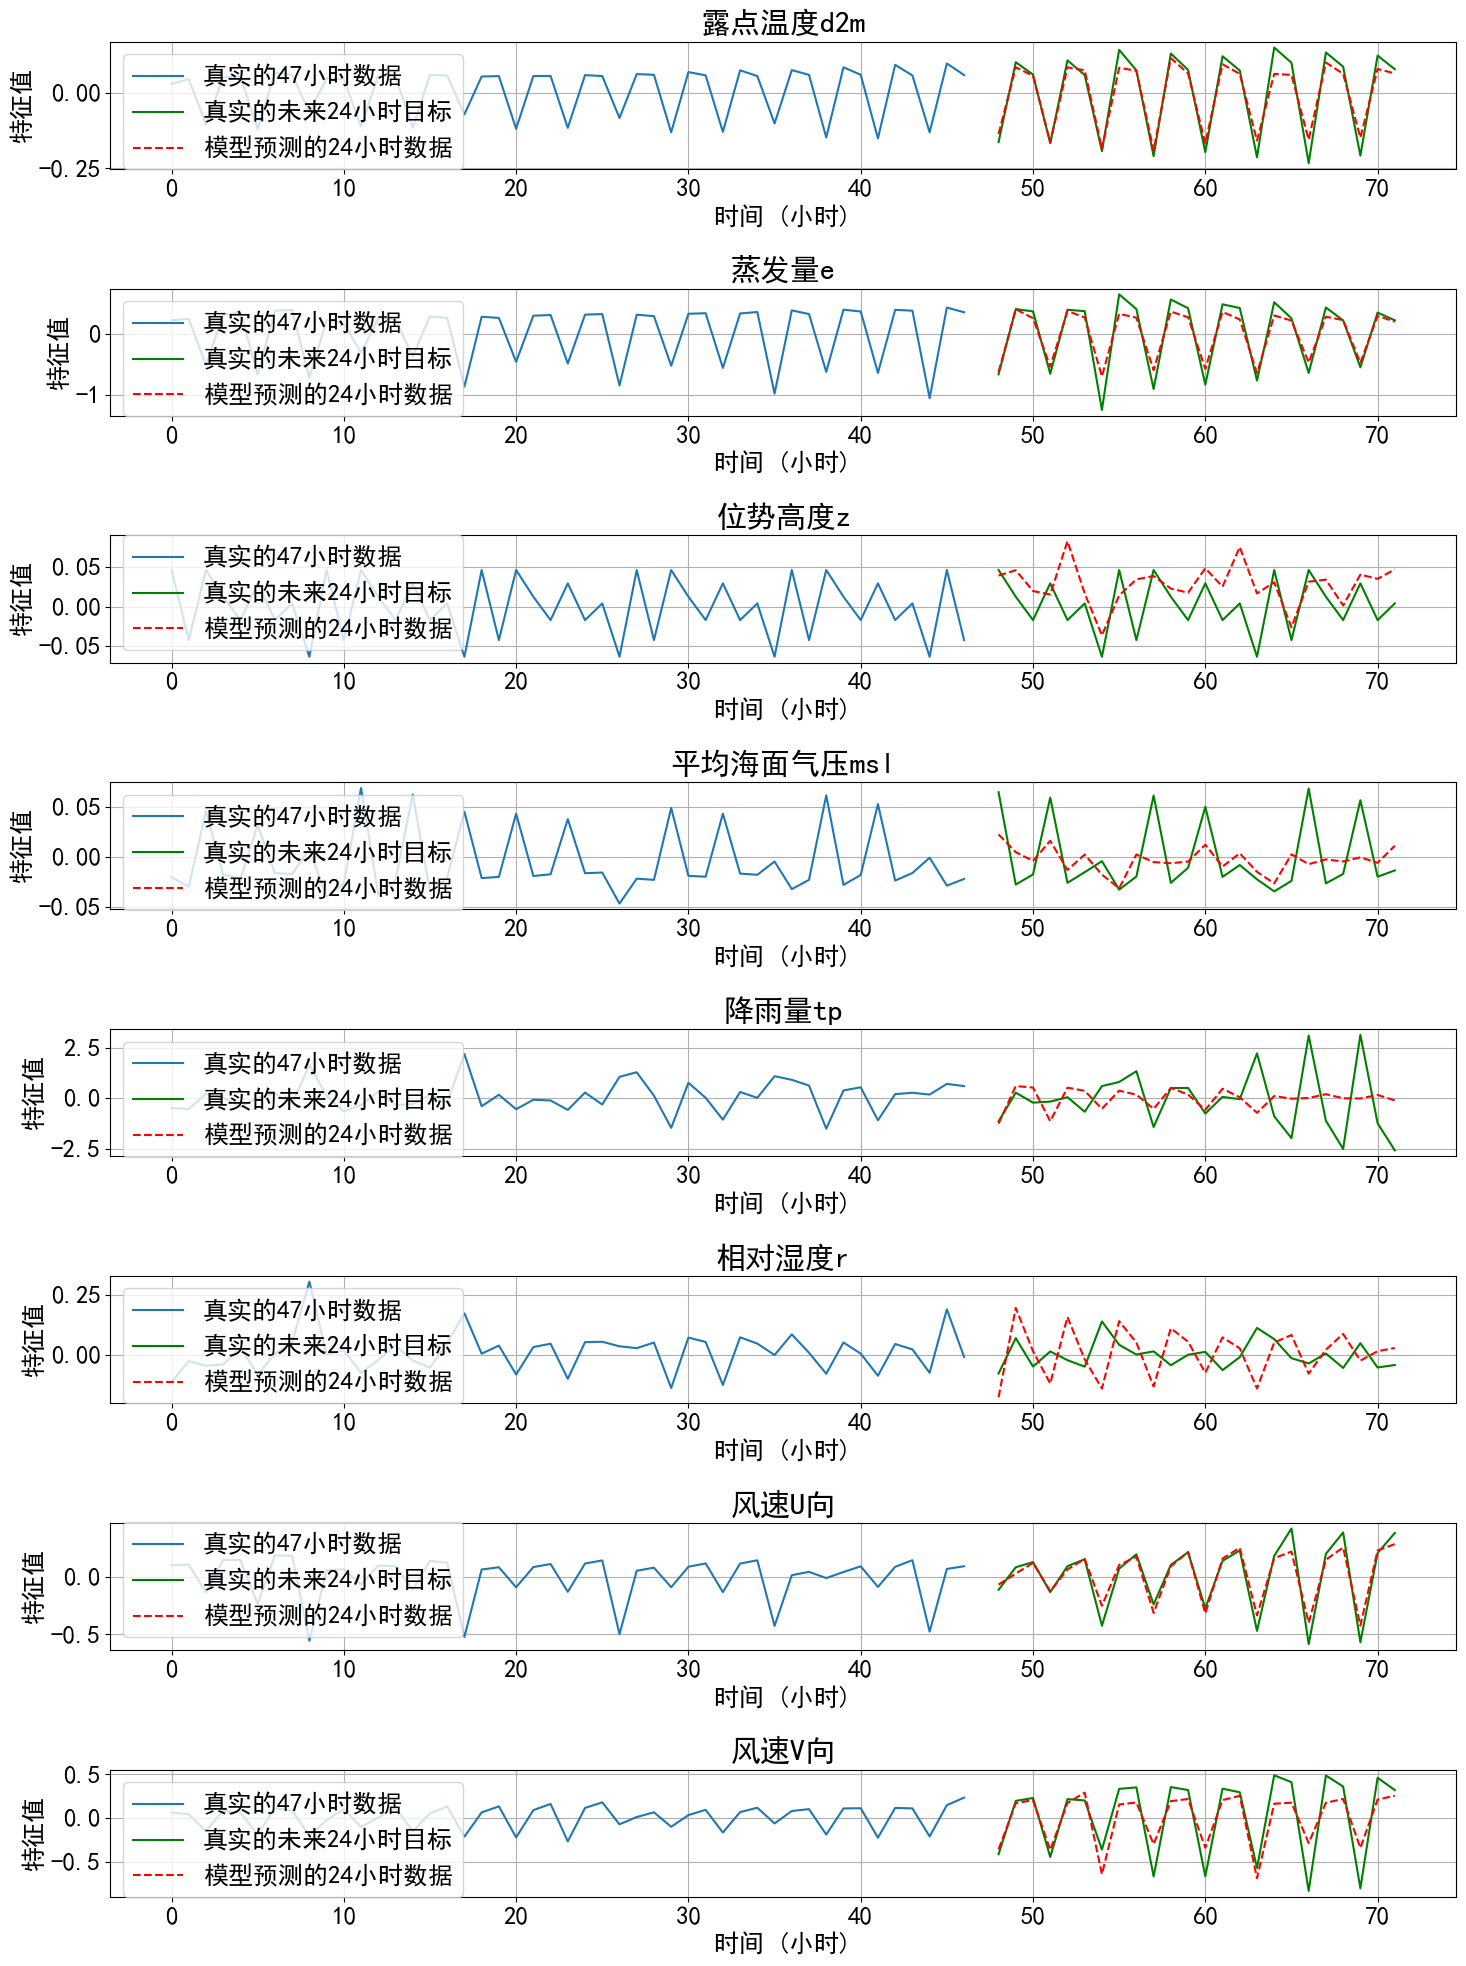

In [9]:
Num_Feature = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
variable_names = ['露点温度d2m', '蒸发量e','位势高度z','平均海面气压msl', '降雨量tp','相对湿度r','风速U向','风速V向']
def evaluate_and_plot_features(model, test_loader):
    for batch in test_loader:
        inputs, targets = batch
        model = model.to(device)
        inputs = inputs.to(device)
        output = model(inputs)
        # 选择第一个样本
        single_input = inputs[0:1].to(device)
        single_target = targets[0:1].to(device)
        output = output[0:1].to(device)
        break  # 只处理第一个batch
    # 将数据移回CPU以便打印或进一步处理
    print(output.shape)

    
    single_input = single_input.cpu().view(-1, Num_Feature)
    single_target = single_target.cpu().view(-1, Num_Feature)
    output = output.cpu().view(-1, Num_Feature)

    # 绘制每个特征的图表
    num_features = Num_Feature
    plt.figure(figsize=(15, 20))
    for i in range(num_features):
        plt.subplot(num_features, 1, i+1)
        plt.plot(single_input[:, i], label='真实的47小时数据')
        plt.plot(range(48, 72), single_target[:, i], 'g', label='真实的未来24小时目标')
        plt.plot(range(48, 72), output[:, i].detach().numpy(), 'r--', label='模型预测的24小时数据')
        plt.title(variable_names[i])
        plt.xlabel('时间 (小时)')
        plt.ylabel(f'特征值')
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

# 调用函数
evaluate_and_plot_features(model, test_loader)